In [1]:
! pip install statsmodels

You should consider upgrading via the 'c:\users\saidj\onedrive\documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('pruebillas.ipynb'), '..'))
os.chdir(root_dir)
sys.path.insert(0, os.path.join(root_dir, 'src'))

In [3]:
import numpy as np
from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from backbone.probability_transformer import ProbabilityTransformer 
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from typing import Tuple
import yaml
from sklearn.metrics import classification_report
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from tqdm import tqdm
from statsmodels.tsa.filters.hp_filter import hpfilter
import os
from sklearn.metrics import accuracy_score
from IPython.display import clear_output
import MetaTrader5 as mt5
import pytz
import talib

pd.options.display.max_rows = 999

In [4]:
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

from backbone.utils.general_purpose import diff_pips

def apply_triple_barrier(
    close_prices, 
    high_prices, 
    low_prices, 
    take_profit_in_pips, 
    stop_loss_in_pips, 
    side,
    max_holding_period=50, 
    pip_size=0.0001
    ):

    barriers = []
    for index in range(len(close_prices)):
        actual_close_price = close_prices[index]
        
        if side[index] == 1:
            # Para una señal de compra
            upper_barrier_level = round(actual_close_price + (take_profit_in_pips * pip_size), 4)
            lower_barrier_level = round(actual_close_price - (stop_loss_in_pips * pip_size), 4)
        elif side[index] == -1:
            # Para una señal de venta
            upper_barrier_level = round(actual_close_price + (stop_loss_in_pips * pip_size), 4)
            lower_barrier_level = round(actual_close_price - (take_profit_in_pips * pip_size), 4)
        else:
            # Si no hay señal, saltar al siguiente índice
            continue
        
        # Evaluar los precios futuros dentro del período máximo de mantenimiento
        for j in range(index + 1, min(index + max_holding_period, len(close_prices))):
            future_close_price = close_prices[j]
            future_high_price = high_prices[j]
            future_low_price = low_prices[j]
            
            if side[index] == 1:

                if future_low_price <= lower_barrier_level:
                    barriers.append((index, 0))  # Etiqueta 0 para stop-loss
                    break

                elif future_high_price >= upper_barrier_level:
                    barriers.append((index, 1))  # Etiqueta 1 para toma de ganancias
                    break

            elif side[index] == -1:
                # Señal de venta: tomar ganancias si se alcanza la barrera inferior

                if future_high_price >= upper_barrier_level:
                    barriers.append((index, 0))  # Etiqueta 0 para stop-loss
                    break

                elif future_low_price <= lower_barrier_level:
                    barriers.append((index, 1))  # Etiqueta 1 para toma de ganancias
                    break

        else:
            barriers.append((index, 2))  # Etiqueta 2 si no se alcanza ninguna barrera
    
    # # Revisar los eventos etiquetados como 2 para determinar si son ganancias o pérdidas
    # for idx, (event_index, label) in enumerate(barriers):
    #     if label == 2:
    #         # Determinar si el precio final fue una ganancia o una pérdida
    #         final_price = close_prices[min(event_index + max_holding_period, len(close_prices) - 1)]
    #         initial_price = close_prices[event_index]
            
    #         if side[event_index] == 1:
    #             # Para una señal de compra
    #             if final_price >= initial_price:
    #                 barriers[idx] = (event_index, 1)  # Etiqueta 1 para toma de ganancias
    #             elif final_price < initial_price:
    #                 barriers[idx] = (event_index, 0)  # Etiqueta 0 para stop-loss
    #         elif side[event_index] == -1:
    #             # Para una señal de venta
    #             if final_price <= initial_price:
    #                 barriers[idx] = (event_index, 1)  # Etiqueta 1 para toma de ganancias
    #             elif final_price > initial_price:
    #                 barriers[idx] = (event_index, 0)  # Etiqueta 0 para stop-loss


    target = [label for _, label in barriers]
    
    return target

In [5]:
def calculate_b_percent(data, window=20, num_std=2):
    # Calcular la SMA
    sma = data['Close'].rolling(window).mean()
    
    # Calcular la Desviación Estándar
    std = data['Close'].rolling(window).std()
    
    # Calcular las Bandas de Bollinger
    upper_band = sma + (std * num_std)
    lower_band = sma - (std * num_std)
    
    # Calcular %B
    b_percent = (data['Close'] - lower_band) / (upper_band - lower_band)
    
    return b_percent

In [6]:
# # establish connection to MetaTrader 5 terminal
# if not mt5.initialize():
#     print("initialize() failed, error code =",mt5.last_error())
#     quit()
 
# # set time zone to UTC
# timezone = pytz.timezone("Etc/UTC")
# # create 'datetime' objects in UTC time zone to avoid the implementation of a local time zone offset
# utc_from = datetime(2024, 4, 30, tzinfo=timezone)
# utc_to = datetime(2024, 7, 1, tzinfo=timezone)
# # get bars from USDJPY M5 within the interval of 2020.01.10 00:00 - 2020.01.11 13:00 in UTC time zone
# rates = mt5.copy_rates_range("EURUSD", mt5.TIMEFRAME_M1, utc_from, utc_to)
 
# # shut down connection to the MetaTrader 5 terminal
# mt5.shutdown()
 
# # create DataFrame out of the obtained data
# eurusd = pd.DataFrame(rates)
# # convert time in seconds into the 'datetime' format
# eurusd['time']=pd.to_datetime(eurusd['time'], unit='s')

# eurusd = eurusd.rename(columns={
#   'time':'Date', 
#   'open':'Open', 
#   'high':'High', 
#   'low':'Low', 
#   'close':'Close', 
#   'tick_volume':'Volume'
# })

# eurusd

In [7]:
def stgy(prices_with_indicators, window):
    df = prices_with_indicators.copy()
    
    long_signals = (
        (df['SQZ_OFF'] == 1) 
        & (df['SQZ_OFF'].shift(1) == 0)  
        & (df['SQZ'] > 0)  
        & (df['adx'] > 20) 
        & (df['supertrend'] == 1) 
    )

    short_signals = (
        (df['SQZ_OFF'] == 1) 
        & (df['SQZ_OFF'].shift(1) == 0) 
        & (df['SQZ'] < 0) 
        & (df['adx'] > 20)
        & (df['adx'] > 20)
        & (df['supertrend'] == -1) 

    )
    
    df.loc[short_signals, 'side'] = -1
    df.loc[long_signals, 'side'] = 1

    df.dropna(inplace=True)
    return df
    return df

In [8]:
import pandas_ta as ta


symbols_path = './backbone/data/backtest/symbols/EURUSD.csv'
df = pd.read_csv(symbols_path)
df = df[['Date','Close','High','Low','Open']]
df['Date'] = pd.to_datetime(df['Date'])
print('Creando target')

# df = eurusd.copy()


window = 24
rolling_high = df['High'].rolling(window=window).max()
rolling_low = df['Low'].rolling(window=window).min()
rolling_close = df['Close'].rolling(window=window).mean()

# Calcular el punto pivote principal (PP)
pivot = (rolling_high + rolling_low + rolling_close) / 3

# Calcular niveles de resistencia y soporte
df['r1'] = ((2 * pivot) - rolling_low).round(5)
df['s1'] = ((2 * pivot) - rolling_high).round(5)

sti = ta.supertrend(df['High'], df['Low'], df['Close'], length=10, multiplier=3)

df['supertrend'] = sti['SUPERTd_10_3.0']
df['SUPERT_10_3.0'] = sti['SUPERT_10_3.0']

smi = ta.squeeze(df['High'], df['Low'], df['Close'], LazyBear=True)

df['SQZ'] = smi['SQZ_20_2.0_20_1.5']
df['SQZ_ON'] = smi['SQZ_ON']
df['SQZ_OFF'] = smi['SQZ_OFF']
df['SQZ_NO'] = smi['SQZ_NO']

df['rsi'] = talib.RSI(df['Close'])

df['aroon'] = talib.AROONOSC(df['High'], df['High'], timeperiod=10)

df['three_stars'] = talib.CDL3STARSINSOUTH(df.Open, df.High, df.Low, df.Close)
df['closing_marubozu'] = talib.CDLCLOSINGMARUBOZU(df.Open, df.High, df.Low, df.Close)
df['doji'] = talib.CDLDOJI(df.Open, df.High, df.Low, df.Close)
df['doji_star'] = talib.CDLDOJISTAR(df.Open, df.High, df.Low, df.Close)
df['dragon_fly'] = talib.CDLDRAGONFLYDOJI(df.Open, df.High, df.Low, df.Close)
df['engulfing'] = talib.CDLENGULFING(df.Open, df.High, df.Low, df.Close)
df['evening_doji_star'] = talib.CDLEVENINGDOJISTAR(df.Open, df.High, df.Low, df.Close)
df['hammer'] = talib.CDLHAMMER(df.Open, df.High, df.Low, df.Close)
df['hanging_man'] = talib.CDLHANGINGMAN(df.Open, df.High, df.Low, df.Close)
df['marubozu'] = talib.CDLMARUBOZU(df.Open, df.High, df.Low, df.Close)
df['morning_star'] = talib.CDLMORNINGSTAR(df.Open, df.High, df.Low, df.Close)
df['shooting_star'] = talib.CDLSHOOTINGSTAR(df.Open, df.High, df.Low, df.Close)
df['inverted_hammer'] = talib.CDLINVERTEDHAMMER(df.Open, df.High, df.Low, df.Close)

df['morning_star'] = talib.CDLMORNINGSTAR(df.Open, df.High, df.Low, df.Close)
df['evening_star'] = talib.CDLEVENINGSTAR(df.Open, df.High, df.Low, df.Close)

df['three_black_crows'] = talib.CDL3BLACKCROWS(df.Open, df.High, df.Low, df.Close)
df['three_white_soldiers'] = talib.CDL3WHITESOLDIERS(df.Open, df.High, df.Low, df.Close)


Creando target


In [9]:
# Convertir la columna 'Date' a solo fecha (sin hora) para agrupar
df['daily_date'] = df['Date'].dt.floor('D')


data_daily = df[['Date','Open','High','Low','Close']].copy()
data_daily['daily_date'] = data_daily['Date'].dt.floor('D')


# Agrupar los datos por día y calcular los valores OHLC diarios
data_daily = data_daily.groupby('daily_date').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last'
}).reset_index()

# Calcular el ADX en la temporalidad diaria
data_daily['daily_adx'] = talib.ADX(data_daily['High'], data_daily['Low'], data_daily['Close'], timeperiod=14)

# Merge los valores del ADX diario con el DataFrame horario

df = pd.merge_asof(
    df, 
    data_daily[['daily_date', 'daily_adx']].sort_values('daily_date'), 
    on='daily_date', 
)

df['daily_adx'] = df['daily_adx'].shift(24)
df['daily_date'] = df['daily_date'].shift(24)


df['adx'] = talib.ADX(df['High'], df['Low'], df['Close'], timeperiod=14)

In [10]:
df = df.sort_values(by='Date')
df = df.set_index('Date')

df = df.dropna()

instrument = df.copy()
# compute bband sides

instrument['side'] = np.nan

window = 1
instrument = stgy(instrument, window)

instrument.dropna(inplace=True)

In [11]:
apply_triple_barrier?

Signature:
apply_triple_barrier(
    close_prices,
    high_prices,
    low_prices,
    take_profit_in_pips,
    stop_loss_in_pips,
    side,
    max_holding_period=50,
    pip_size=0.0001,
)
Docstring: <no docstring>
File:      c:\users\saidj\appdata\local\temp\ipykernel_22740\4143595788.py
Type:      function

In [12]:
sl = 10
rr = 2
holding_period = 24
pip_size = 0.0001

instrument['target'] = apply_triple_barrier(
    close_prices=instrument['Close'], 
    high_prices=instrument['High'], 
    low_prices=instrument['Low'], 
    stop_loss_in_pips=sl, 
    take_profit_in_pips=sl*rr, 
    max_holding_period=holding_period, 
    pip_size=pip_size,
    side=instrument['side']
)

df.loc[instrument.index, 'side'] = instrument.side
df.loc[instrument.index, 'target'] = instrument.target
df.fillna(0, inplace=True)
# df.reset_index(inplace=True)


# Aplicar la lógica para mantener solo un 1 o -1 por cada secuencia de 1s o -1s consecutivos
df['side'] = df['side'].where(
    (df['side'] == 0) | (df['side'] != df['side'].shift(1)),
    0
)


df['target'] = np.where(df['side'] != 0, df['target'], 0)

display(pd.DataFrame(df[df.side!=0].groupby(by=['side','target'])['target'].count()))



df['dummy_model_pred'] = 1
print(classification_report(df[df.side != 0].target, df[df.side != 0].dummy_model_pred))

target
side target        
-1.0 0.0         31
     1.0         34
     2.0          1
 1.0 0.0         30
     1.0         21

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        61
         1.0       0.47      1.00      0.64        55
         2.0       0.00      0.00      0.00         1

    accuracy                           0.47       117
   macro avg       0.16      0.33      0.21       117
weighted avg       0.22      0.47      0.30       117



c:\users\saidj\onedrive\documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\saidj\onedrive\documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\saidj\onedrive\documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

In [13]:
# df = df.reset_index()
# df['month'] = pd.to_datetime(df['Date']).dt.to_period('M')
# df[df.side != 0].groupby(by=['month','side','target'])[['target']].count()

In [14]:
df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])

close 1.17313
support 1.16828
resistance 1.17341
sl 1.17213
tp 1.17513


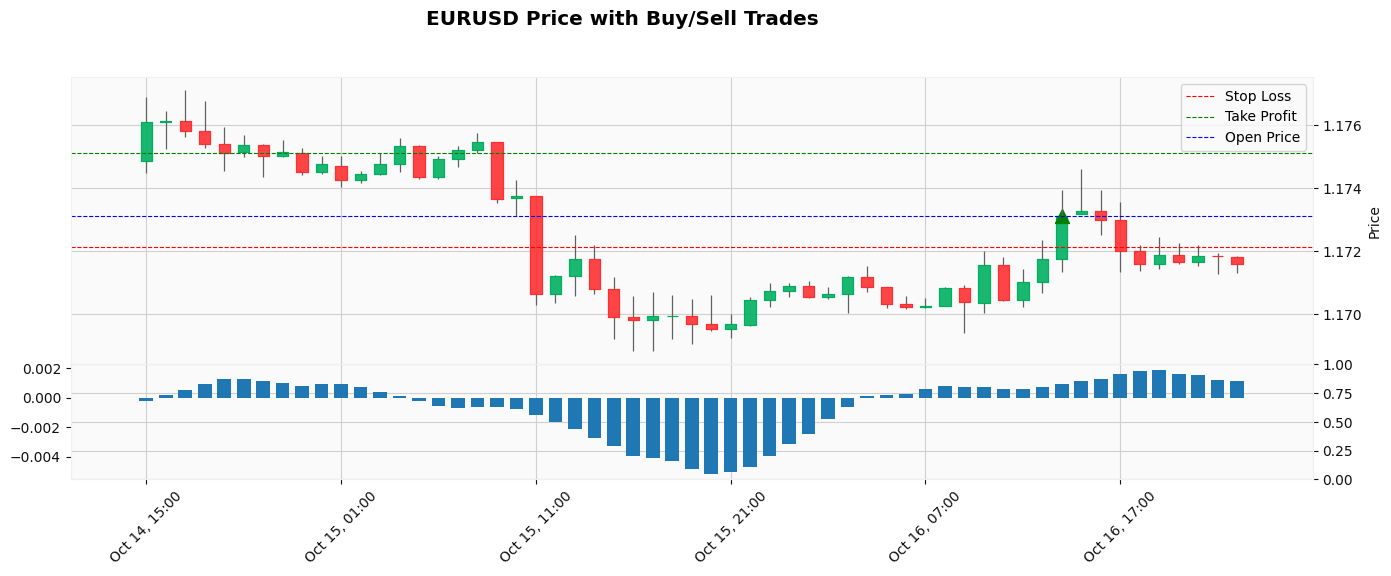

2020-10-14 14:00:00 2020-10-18 14:00:00


In [ ]:
import pandas as pd
import numpy as np
import mplfinance as mpf
import matplotlib.pyplot as plt
from datetime import timedelta


ticker = 'EURUSD'

orders = df[(df.side == 1) & (df.target==1)]

for index, order in orders.iterrows():
    date_from = order.Date - timedelta(hours=48)
    date_to = order.Date + timedelta(hours=48)
    
    date_from_str = date_from.strftime('%Y-%m-%d-%H')
    date_to_str = date_to.strftime('%Y-%m-%d-%H')

    historical_prices = df[
        (df['Date']>date_from_str)
        & (df['Date']<date_to_str)
    ]
    
    historical_prices.set_index('Date', inplace=True)

    # Crear las listas de anotaciones inicializadas con NaN
    open_annotations = [np.nan] * len(historical_prices)
    close_annotations = [np.nan] * len(historical_prices)

    # Buscar las posiciones correspondientes a las fechas de las operaciones
    if order.Date in historical_prices.index:
        open_annotations[historical_prices.index.get_loc(order.Date)] = order.Close
    if order.Date in historical_prices.index:
        close_annotations[historical_prices.index.get_loc(order.Date)] = order.Close

    if order.side == 1:
        stop_loss = round(order.Close - (sl * pip_size), 5)

        pips_to_sl = diff_pips(order.Close, stop_loss, pip_value=pip_size)

        take_profit_in_pips = pips_to_sl * rr
        
        take_profit = round(order.Close + (take_profit_in_pips * pip_size), 5)

        
        color_open = 'green'
        color_close = 'lime'
        marker_open = '^'  # Flecha hacia arriba
    else:

       # Para una señal de venta
        stop_loss = round(order.Close + (sl * pip_size), 4)
    
        pips_to_sl = diff_pips(order.Close, stop_loss, pip_value=pip_size)
    
        take_profit_in_pips = pips_to_sl * rr
        
        take_profit = round(order.Close - (take_profit_in_pips * pip_size), 4)

        color_open = 'brown'
        color_close = 'brown'
        marker_open = 'v'  # Flecha hacia abajo

    # Crear los addplot
    opens = mpf.make_addplot(open_annotations, type='scatter', markersize=100, marker=marker_open, color=color_open)
    ao = mpf.make_addplot(historical_prices['SQZ'],type='bar',width=0.7,panel=1,alpha=1,secondary_y=True)
    
    # supertrend = mpf.make_addplot(historical_prices['SUPERT_10_3.0'])
    # aroon = mpf.make_addplot((historical_prices.aroon), panel=1,color='g')
    # adx = mpf.make_addplot((historical_prices.adx), panel=2,color='r')

    
    print(f'close {order.Close}')
    print(f'sl {stop_loss}')
    print(f'tp {take_profit}')
    
    # Crear el gráfico de velas japonesas con mplfinance
    fig, axlist = mpf.plot(
        historical_prices, 
        type='candle', 
        style='yahoo', 
        returnfig=True, 
        volume=False, 
        title=f'{ticker} Price with Buy/Sell Trades', 
        figratio=(15,5),
        addplot=[opens, ao]
    )

    # Agregar las operaciones al gráfico
    ax = axlist[0]  # Acceder al primer subplot, que contiene el gráfico de velas
    # Agregar líneas horizontales para stop loss, take profit y precio de apertura
    ax.axhline(stop_loss, color='red', linewidth=0.8, linestyle='--', label='Stop Loss')
    ax.axhline(take_profit, color='green', linewidth=0.8, linestyle='--', label='Take Profit')
    ax.axhline(order.Close, color='blue', linewidth=0.8, linestyle='--', label='Open Price')

    # Añadir etiquetas y leyenda
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    plt.xticks(rotation=45)

    plt.show()
    
    print(date_from, date_to)
    
    a = input()  # Pausa para la interacción del usuario
    clear_output()
    
    plt.close(fig)  # Cerrar la figura para la siguiente iteración

In [ ]:
df = df.reset_index()

df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
start_date = '2018-01-01'
end_date = '2019-01-01'

df_bt = df[(df.Date > start_date) & (df.Date < end_date)].set_index('Date')

In [ ]:
from backtesting import Strategy
import talib

def SIDE():
    return df_bt.side

class Bband(Strategy):
    max_hold_period = holding_period
    hold_period = 0
    sl = sl
    rr = rr
    pips = pip_size
    
    def init(self):
        self.side = self.I(SIDE)
    
    def next(self):

        close = self.data.Close[-1]
        if self.trades:
            self.hold_period += 1

            if self.hold_period > self.max_hold_period:
                self.position.close()
                self.hold_period = 0
        

        if self.side[-1] == -1 and not self.trades:
            sl = round(close + (self.sl * self.pips), 4)
            tp = round(close - (self.rr * self.sl * self.pips), 4)
            self.sell(sl=sl, tp=tp, size=0.2)

        if self.side[-1] == 1 and not self.trades:
            sl = round(close - (self.sl * self.pips), 4)
            tp = round(close + (self.rr * self.sl * self.pips), 4)
            self.buy()


In [ ]:
from backtesting import Backtest

bt = Backtest(df_bt, Bband, cash=1000)
stats = bt.run()
stats

In [ ]:
bt.plot()
